In [5]:
import os
import json
import pandas as pd
from tqdm import tqdm

# Ruta a los archivos JSON
folder_path = r"C:\Users\carda\Downloads\Data Science Henry DataFt25\PF Henry\data\Google Maps"

# Ruta para guardar los archivos procesados
processed_folder = r"C:\Users\carda\Downloads\Data Science Henry DataFt25\PF Henry\data\Google Maps\output"

# Crear la carpeta para guardar archivos procesados si no existe
os.makedirs(processed_folder, exist_ok=True)

# Procesar los archivos JSON
files_to_process = [f for f in os.listdir(folder_path) if f.endswith(".json")]  # Filtrar solo archivos JSON
for file_name in tqdm(files_to_process, desc="Procesando archivos JSON"):
    file_path = os.path.join(folder_path, file_name)
    processed_data = []  # Lista para almacenar datos procesados
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                try:
                    # Cargar cada línea como JSON
                    data = json.loads(line.strip())
                    processed_data.append(data)
                    if len(processed_data) >= 50:  # Solo tomar los primeros 50 registros
                        break
                except json.JSONDecodeError as e:
                    print(f"Error en línea del archivo {file_name}: {e}")
        
        # Si hay datos procesados, guardarlos en un archivo CSV
        if processed_data:
            df = pd.DataFrame(processed_data)
            output_path = os.path.join(processed_folder, f"processed_{file_name.replace('.json', '.csv')}")
            df.to_csv(output_path, index=False)
    except Exception as e:
        print(f"Error al procesar el archivo {file_name}: {e}")

print("Procesamiento completado y archivos CSV guardados.")



Procesando archivos JSON: 100%|█████████████| 622/622 [00:03<00:00, 184.26it/s]

Procesamiento completado y archivos CSV guardados.


In [6]:
# Crear una lista para almacenar los DataFrames
dataframes = []

# Cargar todos los archivos procesados
processed_files = os.listdir(processed_folder)
for file_name in processed_files:
    if file_name.endswith(".csv"):
        file_path = os.path.join(processed_folder, file_name)
        try:
            df = pd.read_csv(file_path)
            dataframes.append(df)
        except Exception as e:
            print(f"Error al cargar {file_name}: {e}")

# Combinar todos los DataFrames en uno solo
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Se han combinado {len(dataframes)} archivos. Total de filas: {len(combined_df)}")
else:
    print("No se encontraron archivos procesados para combinar.")


Se han combinado 622 archivos. Total de filas: 31100


In [7]:
# Verificar las primeras filas y columnas
if 'combined_df' in locals():
    print("Columnas disponibles en el DataFrame:", combined_df.columns)
    combined_df.head()
else:
    print("El DataFrame combinado no está definido.")


Columnas disponibles en el DataFrame: Index(['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id',
       'address', 'description', 'latitude', 'longitude', 'category',
       'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state',
       'relative_results', 'url'],
      dtype='object')


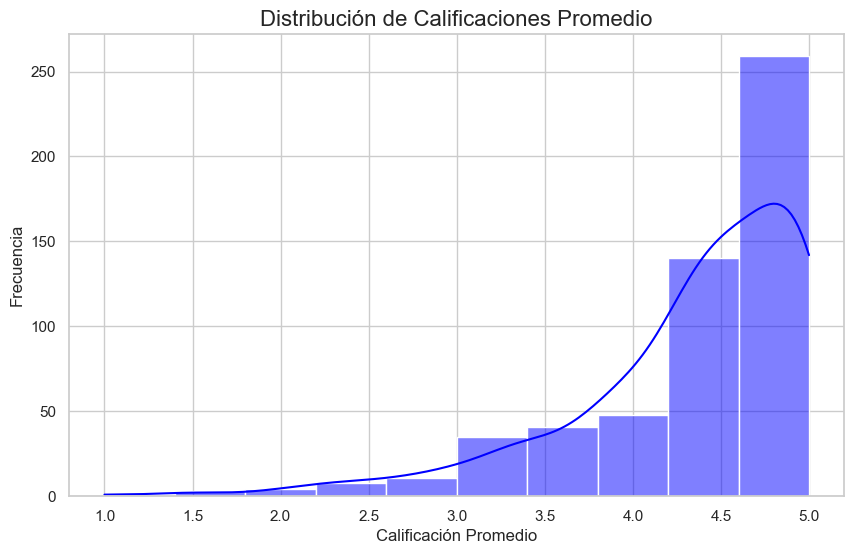

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set(style="whitegrid")

# Histograma de calificaciones promedio
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x="avg_rating", bins=10, kde=True, color="blue")
plt.title("Distribución de Calificaciones Promedio", fontsize=16)
plt.xlabel("Calificación Promedio", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.show()


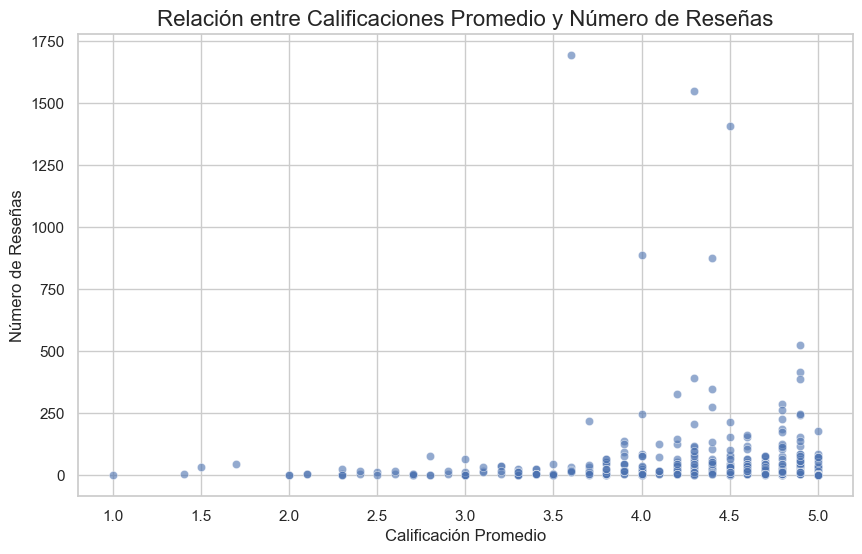

In [9]:
# Scatter plot para ver la relación entre calificación promedio y número de reseñas
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x="avg_rating", y="num_of_reviews", alpha=0.6)
plt.title("Relación entre Calificaciones Promedio y Número de Reseñas", fontsize=16)
plt.xlabel("Calificación Promedio", fontsize=12)
plt.ylabel("Número de Reseñas", fontsize=12)
plt.show()


C:\Users\carda\AppData\Local\Temp\ipykernel_46056\3069600883.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hours_count.values, y=simplified_labels, palette="coolwarm")


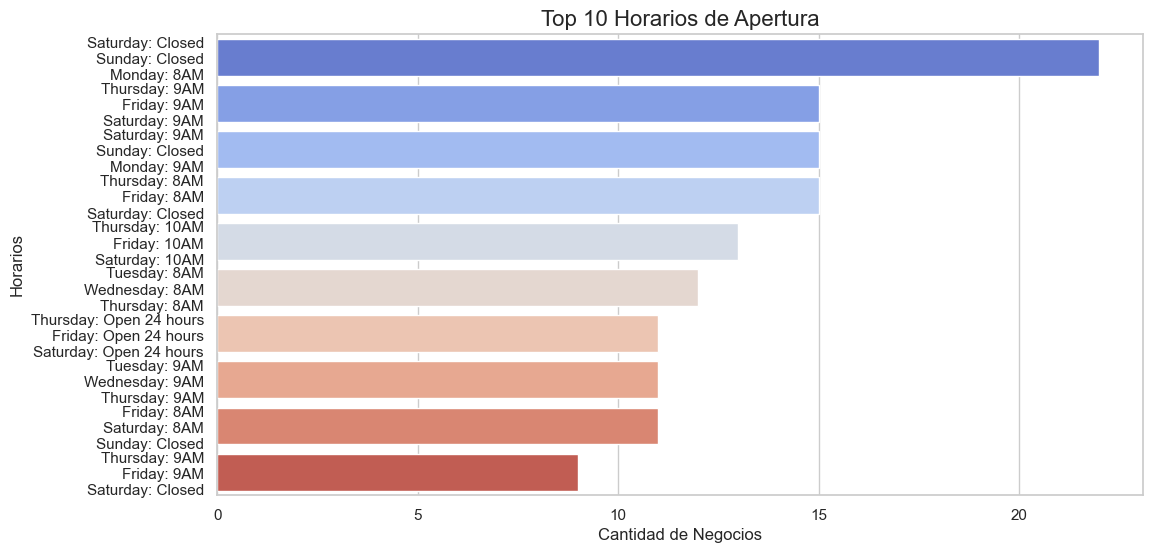

In [12]:
# Limpiar la columna de "hours"
import ast

def process_hours(hours):
    try:
        # Convertir cadenas de listas a listas reales si es necesario
        if isinstance(hours, str):
            hours_list = ast.literal_eval(hours)
            if isinstance(hours_list, list):
                # Solo tomar el primer horario de cada día para simplificar
                return ", ".join([f"{day}: {time.split('–')[0]}" for day, time in hours_list[:3]])  # Limitar a los primeros 3 días
        return hours
    except Exception as e:
        return "Unknown"

# Verificar si el DataFrame combinado está cargado
if 'combined_df' in locals():
    if "hours" in combined_df.columns:
        # Aplicar la función de limpieza
        combined_df["cleaned_hours"] = combined_df["hours"].apply(process_hours)

        # Contar los horarios procesados y obtener el top 10
        hours_count = combined_df["cleaned_hours"].value_counts().head(10)

        # Simplificar las etiquetas largas en el eje Y
        simplified_labels = ["\n".join(label.split(", ")) for label in hours_count.index]

        # Graficar los resultados
        plt.figure(figsize=(12, 6))
        sns.barplot(x=hours_count.values, y=simplified_labels, palette="coolwarm")
        plt.title("Top 10 Horarios de Apertura", fontsize=16)
        plt.xlabel("Cantidad de Negocios", fontsize=12)
        plt.ylabel("Horarios", fontsize=12)
        plt.tight_layout(pad=2.0)  # Ajustar para evitar problemas con los márgenes
        plt.show()
    else:
        print("La columna 'hours' no está disponible en el DataFrame.")
else:
    print("El DataFrame combinado no está definido. Asegúrate de cargarlo en la celda 2.")


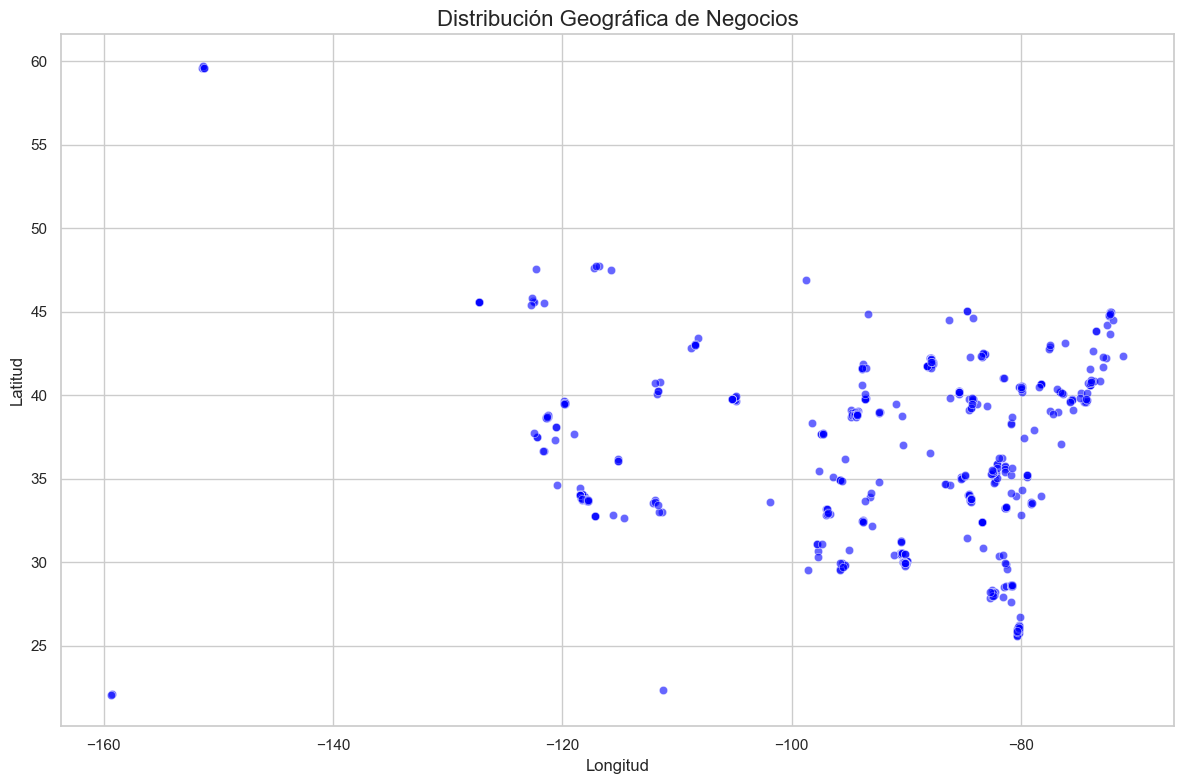

In [13]:
# Verificar si las columnas de latitud y longitud están disponibles
if 'latitude' in combined_df.columns and 'longitude' in combined_df.columns:
    plt.figure(figsize=(12, 8))
    
    # Graficar puntos en un mapa simple
    sns.scatterplot(
        data=combined_df,
        x="longitude",
        y="latitude",
        alpha=0.6,  # Ajustar la transparencia
        color="blue"
    )
    plt.title("Distribución Geográfica de Negocios", fontsize=16)
    plt.xlabel("Longitud", fontsize=12)
    plt.ylabel("Latitud", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Las columnas 'latitude' y 'longitude' no están disponibles en el DataFrame.")


C:\Users\carda\AppData\Local\Temp\ipykernel_46056\1297771845.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis")


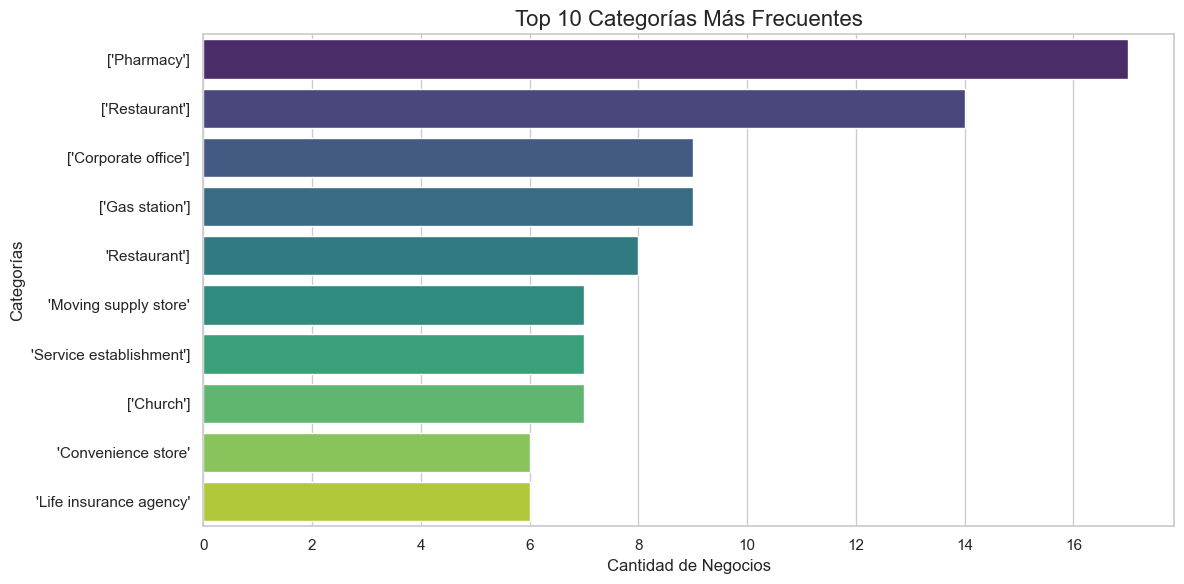

In [14]:
# Verificar si la columna 'category' está disponible
if "category" in combined_df.columns:
    # Dividir las categorías si están en formato de lista o separadas por comas
    def split_categories(categories):
        if isinstance(categories, str):
            return [cat.strip() for cat in categories.split(",")]
        return []

    # Crear una nueva columna con categorías separadas
    combined_df["split_categories"] = combined_df["category"].apply(split_categories)

    # Explosión para contar cada categoría por separado
    exploded_categories = combined_df.explode("split_categories")

    # Contar la frecuencia de las categorías
    category_counts = exploded_categories["split_categories"].value_counts().head(10)

    # Gráfico de barras de las categorías más comunes
    plt.figure(figsize=(12, 6))
    sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis")
    plt.title("Top 10 Categorías Más Frecuentes", fontsize=16)
    plt.xlabel("Cantidad de Negocios", fontsize=12)
    plt.ylabel("Categorías", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("La columna 'category' no está disponible en el DataFrame.")


C:\Users\carda\AppData\Local\Temp\ipykernel_46056\2244490426.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x="price_level", y="avg_rating", palette="coolwarm")


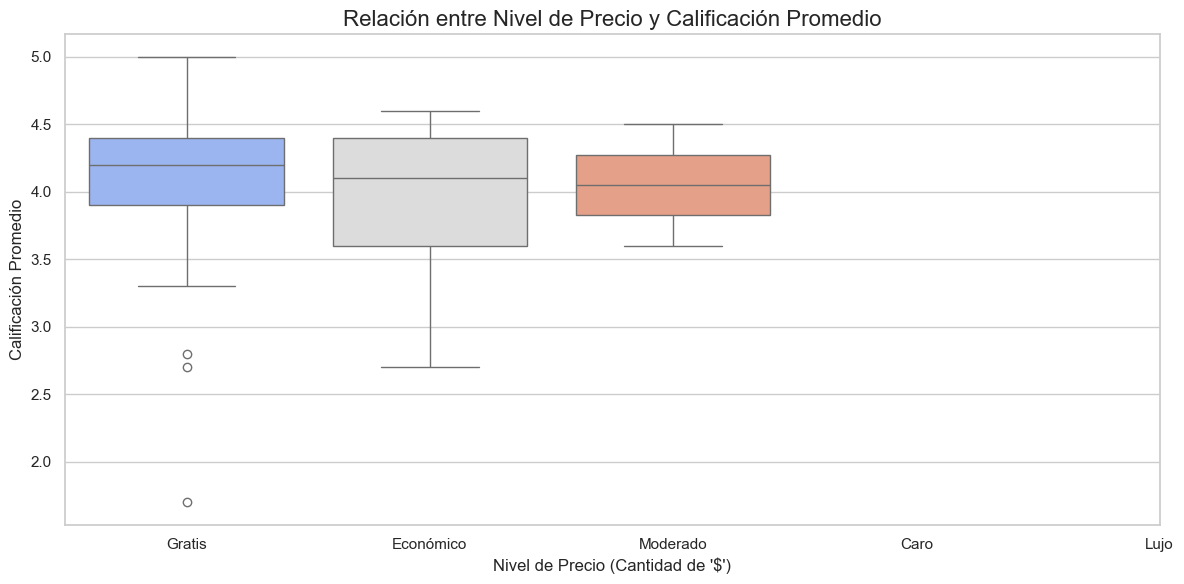

In [15]:
# Verificar si las columnas 'avg_rating' y 'price' están disponibles
if "avg_rating" in combined_df.columns and "price" in combined_df.columns:
    # Crear una nueva columna para la longitud del símbolo de precio ('$' -> económico, '$$$$' -> caro)
    combined_df["price_level"] = combined_df["price"].apply(lambda x: len(x) if isinstance(x, str) else 0)

    # Filtrar para considerar solo negocios con calificación promedio válida y un nivel de precio definido
    filtered_df = combined_df[(combined_df["avg_rating"].notna()) & (combined_df["price_level"] > 0)]

    # Boxplot para mostrar la distribución de calificaciones por nivel de precio
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=filtered_df, x="price_level", y="avg_rating", palette="coolwarm")
    plt.title("Relación entre Nivel de Precio y Calificación Promedio", fontsize=16)
    plt.xlabel("Nivel de Precio (Cantidad de '$')", fontsize=12)
    plt.ylabel("Calificación Promedio", fontsize=12)
    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["Gratis", "Económico", "Moderado", "Caro", "Lujo"])
    plt.tight_layout()
    plt.show()
else:
    print("Las columnas 'avg_rating' y/o 'price' no están disponibles en el DataFrame.")


state
Open ⋅ Closes 5PM         36
Open ⋅ Closes 6PM         33
Permanently closed        30
Open 24 hours             27
Open ⋅ Closes 7PM         26
Closed ⋅ Opens 8AM Mon    25
Closed ⋅ Opens 9AM Mon    19
Open ⋅ Closes 9PM         16
Open now                  14
Open ⋅ Closes 8PM         12
Name: count, dtype: int64


C:\Users\carda\AppData\Local\Temp\ipykernel_46056\1211418196.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_summary.values[:10], y=state_summary.index[:10], palette="coolwarm")
C:\Users\carda\AppData\Local\Temp\ipykernel_46056\1211418196.py:13: UserWarning: Glyph 8901 (\N{DOT OPERATOR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\carda\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8901 (\N{DOT OPERATOR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


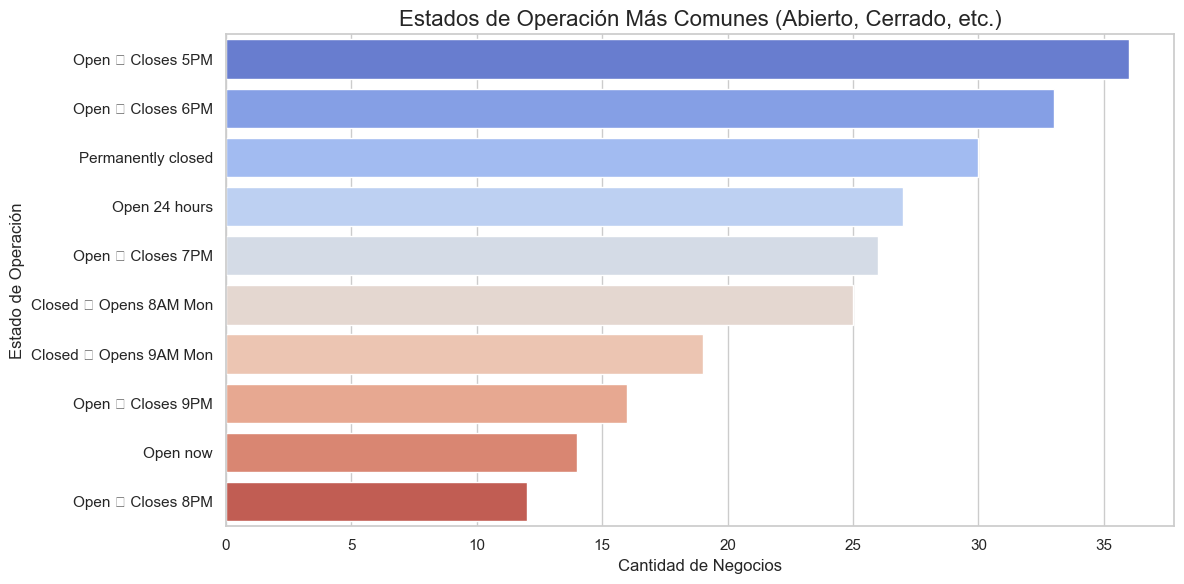

In [21]:
# Contar los valores únicos en la columna "state"
state_summary = combined_df["state"].value_counts()

# Mostrar los valores más comunes
print(state_summary.head(10))

# Graficar los valores más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x=state_summary.values[:10], y=state_summary.index[:10], palette="coolwarm")
plt.title("Estados de Operación Más Comunes (Abierto, Cerrado, etc.)", fontsize=16)
plt.xlabel("Cantidad de Negocios", fontsize=12)
plt.ylabel("Estado de Operación", fontsize=12)
plt.tight_layout()
plt.show()
